# Analyzing Power Users

### Introduction

Now that we have identified written the query to determine the cumulative percentage of spend, the next step is to identify our power users.  Then we can see behavior of our power users.  

### Loading our Data

Let's start by connecting to our data.

In [6]:
from sqlalchemy import create_engine
import pandas as pd
# change the jeffreykatz to your postgres username
conn_string = 'postgresql://jeffreykatz@localhost/ecommerce'
engine = create_engine(conn_string)

transactions_df = pd.read_sql('select * from transactions', engine)
transactions_df[:2]

,index,transaction_id,customer_id,product,gender,device_type,country,state,city,category,...,delivery_type,quantity,transaction_start,transaction_result,amount,individual_price,month,week,dow,hour
0,0,40170,1348959766,Hair Band,Female,Web,United States,New York,New York City,Accessories,...,one-day deliver,12,1,0,6910.0,576.0,11.0,46.0,4.0,22.0
1,1,33374,2213674919,Hair Band,Female,Web,United States,California,Los Angles,Accessories,...,one-day deliver,17,1,1,1699.0,100.0,5.0,19.0,6.0,6.0


And we have our percentage of user spend.

In [1]:

percent_spend_df = pd.read_csv('./user_percentage_spend.csv', index_col = 0)
percent_spend_df[:3]

,customer_id,total_amount,percentage_spend
0,1929979702,894869.0,0.002978
1,1430453333,840000.0,0.005774
2,1884522075,767733.0,0.008329


### Identifying power users

Ok so next up is to identify our power users.  We can do so by selecting the rows where the percentage spend is less than .80, or 80 percent.

In [2]:
power_users_df = percent_spend_df[percent_spend_df['percentage_spend'] < .80]
power_users_df[:3]

,customer_id,total_amount,percentage_spend
0,1929979702,894869.0,0.002978
1,1430453333,840000.0,0.005774
2,1884522075,767733.0,0.008329


In [3]:
power_users_df.shape, percent_spend_df.shape

((19536, 3), (64998, 3))

So we can see that 19500 users account for 80 percent of our total revenue.  This is out of a total customer base of almost 65,000.  In other words `30%` of our users account for `80%` of the revenue.  That's pretty close to what our 80 - 20 rule predicted.

> These power user transactions are indeed a subset of overall transactions, but the dimensions of our transactions look pretty similar to the dimensions of our users.  So that seems to suggest that each user generally just has one transaction in our transactions table.

It's good to play with this number, for example let's see the number of users that account for 50 percent of our spend.

In [17]:
super_users_df = percent_spend_df[percent_spend_df['percentage_spend'] < .50]
super_users_df.shape, percent_spend_df.shape

((5360, 3), (64998, 3))

In [18]:
5360/64998

0.08246407581771747

So here, we see that just less that 8 percent of our users account for 50 percent of our spend.  It's a judment call, but this seems like an even more interesting subset to analyze.  Let's do that, and stick with our super users.

Now that we have the super users, we can try to identify *the behavior* of our super users.  We can do so with the following.  

First set the index of the transactions dataframe to our customer_id.

In [7]:
transactions_df.index = transactions_df.customer_id

super_users_transactions_df = transactions_df.loc[super_users_df.customer_id]

And let's confirm that we have selected a subset of the transactions.

In [20]:
super_users_transactions_df.shape, transactions_df.shape

((5586, 21), (65535, 21))

Now that we have identified transactions by super users, we can then use our group by functions, to find the characteristics of our super user transactions.

In [ ]:
from lib import *
# group_and_print(table_name, cols, target, engine, order_by_col = False)

To use the `group_and_print` function, we need a *table* to query, not a dataframe.  So let's save our `super_user_transactions` as a table.  And then we can query it.

> So first we reset the index.

In [33]:
super_users_transactions_df.index = super_users_transactions_df['index']
super_users_transactions_df_updated = super_users_transactions_df.drop(columns = ['index'])

super_users_transactions_df_updated[:2]


,transaction_id,customer_id,product,gender,device_type,country,state,city,category,customer_login_type,delivery_type,quantity,transaction_start,transaction_result,amount,individual_price,month,week,dow,hour
index,,,,,,,,,,,,,,,,,,,,
12002,15335,1929979702,Shirt,Male,Web,United States,Washington,Seattle,Clothing,Member,Normal Delivery,12,1,1,894869.0,NaN,3.0,10.0,0.0,13.0
11347,13787,1430453333,Shirt,Male,Web,United States,Washington,Seattle,Clothing,Member,Normal Delivery,13,1,1,840000.0,NaN,9.0,40.0,1.0,6.0


In [34]:
super_users_transactions_df_updated.to_sql('super_user_txns', engine, if_exists = 'replace')

586

In [39]:
time_cols = ['month', 'week', 'dow', 'hour']
customer_cols = ['gender', 'customer_id']

product_cols = ['product', 'category', 'individual_price']
channel_cols = ['device_type', 'customer_login_type', 'delivery_type']
transaction_cols = ['transaction_id', 'quantity', 'transaction_start', 'transaction_result']

And now we can use our group and print functions to learn characteristics of our super users.

product


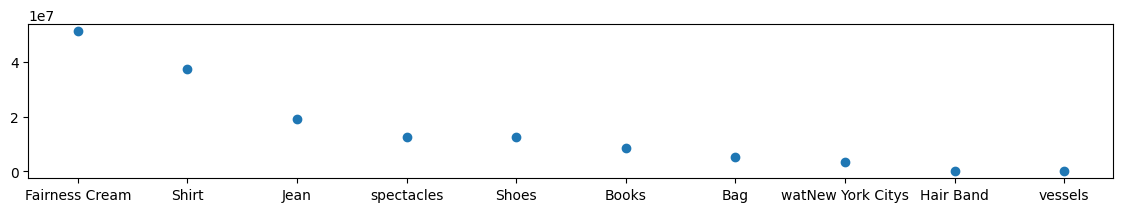

category


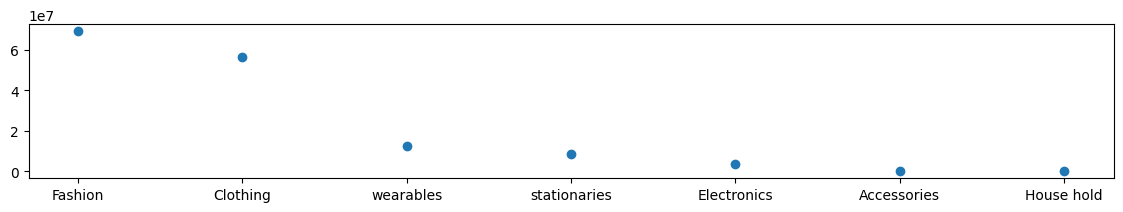

individual_price


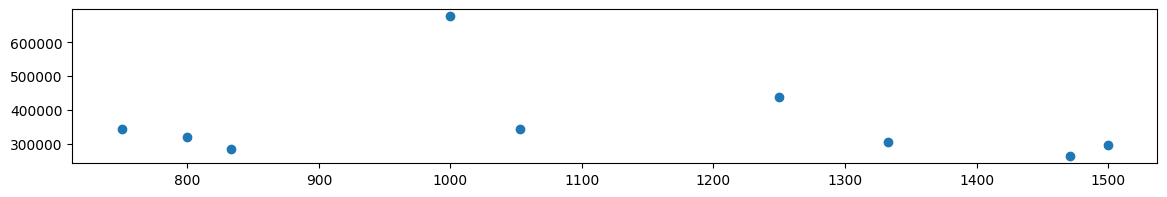

In [37]:
from lib import *
group_and_print('super_user_txns', product_cols, 'amount', engine)

And we can always compare this against our overall transactions.

product


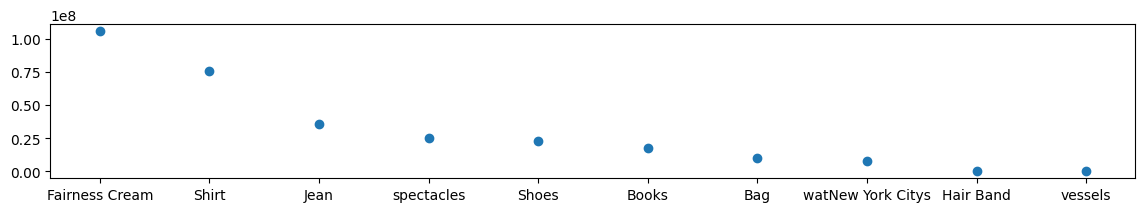

category


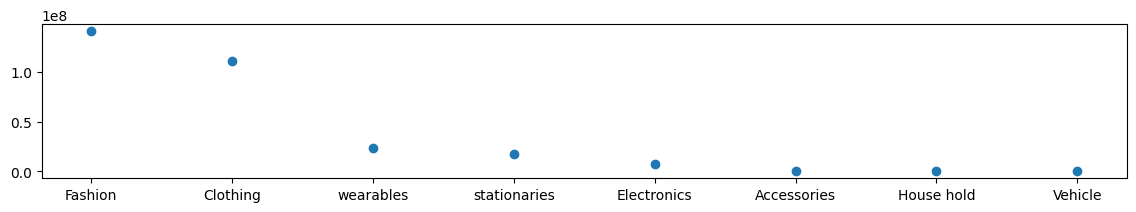

individual_price


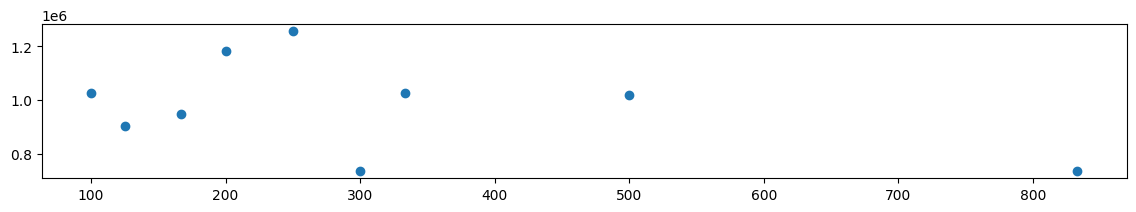

In [38]:
group_and_print('transactions', product_cols, 'amount', engine)

The biggest difference in this category appears to be in the price of the product. This may suggest an ability to go after a more luxury market.  We should also explore other columns.  For example, are these customers members, like we would expect.

customer_login_type


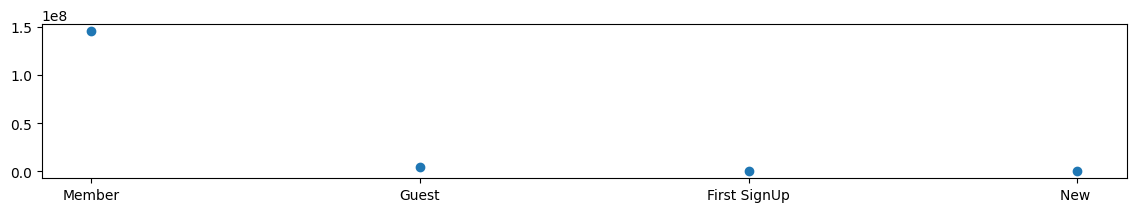

In [43]:
group_and_print('super_user_txns', channel_cols[1:2], 'amount', engine)

We can see a lot, but not all are.  Perhaps we can make sure there is an outreach program to retain these high spending customers who are not yet members.  As a follow up, identify these users, and determine what percentage of spend they account for -- it could be significant.

### Summary 

In this lesson, we saw that once we wrote our query to calculate the running percentage spend, we then identified a subset of users as super users -- who accounted for 50 percent of our spend.

From there, we used the index to find the transactions involving our power users.  And we saved this subset of transactions as a new table.  

Finally, we used our `group_and_print` function to analyze this subset of data. 

An overall point is that once we have identified an interesting subset of data, we can just use our `group_and_print` functions all over again.  In this case, we did this for our power users, but we also could have done it with another subset of our data, like analyzing users from a particular geographic region.